In [59]:
!pip install pyldavis

In [60]:
#importing necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pyLDAvis.gensim_models
from tqdm import tqdm
import random
random.seed(42)
np.random.seed(42)

In [61]:
def scrape_book_data(urls):
    """Scrapes book details, including genres, from Goodreads URLs."""
    book_data = []
    headers = {"User-Agent": "Mozilla/5.0"}

    for url in urls:
        page = requests.get(url, headers=headers).text
        soup = BeautifulSoup(page, "html.parser")

        # Extract book details
        title = soup.find("h1", {"data-testid": "bookTitle"})
        author = soup.find("span", {"data-testid": "authorName"})
        rating_element = soup.find("div", {"class": "RatingStatistics__rating"})
        description = soup.find("div", {"class": "BookPageMetadataSection__description"})

        # Extract genres
        genre_elements = soup.select('span.BookPageMetadataSection__genreButton')  # Goodreads genre tags
        genres = [genre.text.strip() for genre in genre_elements] if genre_elements else ["N/A"]

        title = title.text.strip() if title else "N/A"
        author = author.text.strip() if author else "N/A"

        rating = None
        if rating_element:
            rating_text = rating_element.text.strip()
            rating = re.sub(r"[^0-9.]", "", rating_text)  # Remove non-numeric characters
            try:
                rating = float(rating)
            except ValueError:
                rating = None

        description = description.text.strip() if description else "N/A"

        book_data.append({
            "Title": title,
            "Author": author,
            "Rating": rating,
            "Description": description,
            "Genres": genres  # Include extracted genres
        })

    return book_data

# Example usage
book_urls = ["https://www.goodreads.com/book/show/4214.Life_of_Pi"]
book_details = scrape_book_data(book_urls)
print(book_details)


[{'Title': 'Life of Pi', 'Author': 'N/A', 'Rating': 3.94, 'Description': 'Life of Pi is a fantasy adventure novel by Yann Martel published in 2001. The protagonist, Piscine Molitor "Pi" Patel, a Tamil boy from Pondicherry, explores issues of spirituality and practicality from an early age. He survives 227 days after a shipwreck while stranded on a boat in the Pacific Ocean with a Bengal tiger named Richard Parker.', 'Genres': ['Fiction', 'Fantasy', 'Classics', 'Book Club', 'Adventure', 'Magical Realism', 'Novels']}]


In [62]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import requests
from bs4 import BeautifulSoup
import re

# Download stopwords if not already downloaded
nltk.download("stopwords")
nltk.download("punkt")

def clean_text(text):
    """Lowercases text, removes punctuation, tokenizes, and removes stopwords."""
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(tokens)  # Reconstruct text

def scrape_book_data(urls):
    """Scrapes and cleans book details from Goodreads URLs, including genres."""
    book_data = []
    headers = {"User-Agent": "Mozilla/5.0"}

    for url in urls:
        page = requests.get(url, headers=headers).text
        soup = BeautifulSoup(page, "html.parser")

        # Extract book details
        title = soup.find("h1", {"data-testid": "bookTitle"})
        author = soup.find("span", {"data-testid": "authorName"})
        rating_element = soup.find("div", {"class": "RatingStatistics__rating"})
        description = soup.find("div", {"class": "BookPageMetadataSection__description"})

        # Extract genres
        genre_elements = soup.select('span.BookPageMetadataSection__genreButton')  # Goodreads genre tags
        genres = [genre.text.strip() for genre in genre_elements] if genre_elements else ["N/A"]

        # Clean extracted data
        title = clean_text(title.text.strip()) if title else "N/A"
        author = clean_text(author.text.strip()) if author else "N/A"

        rating = None
        if rating_element:
            rating_text = rating_element.text.strip()
            rating = re.sub(r"[^0-9.]", "", rating_text)  # Keep only numeric rating
            try:
                rating = float(rating)
            except ValueError:
                rating = None

        description = clean_text(description.text.strip()) if description else "N/A"

        book_data.append({
            "Title": title,
            "Author": author,
            "Rating": rating,
            "Description": description,
            "Genres": genres  # Include extracted genres
        })

    return book_data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [64]:
urls = [
    "https://www.goodreads.com/book/show/3.Harry_Potter_and_the_Sorcerer_s_Stone",
    "https://www.goodreads.com/book/show/2767052-the-hunger-games",
    "https://www.goodreads.com/book/show/2657.To_Kill_a_Mockingbird",
    "https://www.goodreads.com/book/show/1885.Pride_and_Prejudice",
    "https://www.goodreads.com/book/show/4671.The_Great_Gatsby",
    "https://www.goodreads.com/book/show/4214.Life_of_Pi",
    "https://www.goodreads.com/book/show/170448.Animal_Farm",
    "https://www.goodreads.com/book/show/40961427-1984",
    "https://www.goodreads.com/book/show/5107.The_Catcher_in_the_Rye",
    "https://www.goodreads.com/book/show/19063.The_Book_Thief",
    "https://www.goodreads.com/book/show/5907.The_Hobbit",
    "https://www.goodreads.com/book/show/33.The_Lord_of_the_Rings",
    "https://www.goodreads.com/book/show/865.The_Alchemist",
    "https://www.goodreads.com/book/show/234225.Dune",
    "https://www.goodreads.com/book/show/11127.The_Chronicles_of_Narnia"
]

books = scrape_book_data(urls)

In [65]:
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Extract Descriptions and Map to Genres
genre_wise_descriptions = defaultdict(list)

for book in books:
    if "Description" in book and book["Description"] != "N/A" and "Genres" in book:
        for genre in book["Genres"]:
            genre_wise_descriptions[genre].append(book["Description"])  # Group by genre

# Step 3: Apply CountVectorizer for Feature Extraction (Per Genre)
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.7)

genre_feature_sets = {}
for genre, descriptions in genre_wise_descriptions.items():
    try:
        X = vectorizer.fit_transform(descriptions)
        genre_feature_sets[genre] = vectorizer.get_feature_names_out()
    except ValueError as e:
        print(f" Skipping genre '{genre}' due to vectorization error: {e}")

# Step 4: Print Extracted Features Per Genre
for genre, features in genre_feature_sets.items():
    print(f"Extracted Features for {genre}:", features)


⚠️ Skipping genre 'Magic' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Childrens' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Middle Grade' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Romance' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Read For School' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Historical Romance' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Magical Realism' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Politics' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'Coming Of Age' due to vectorization error: max_df corresponds to < documents than min_df
⚠️ Skipping genre 'War' due to vectorizatio

ADDITIONAL QUESTION OF ASSIGNMENT - 4

In [66]:
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Function to split text into N sections
def split_text_sections(text, num_sections=3):
    words = text.split()  # Tokenize text into words
    split_points = np.array_split(range(len(words)), num_sections)  # Create section indices
    return [" ".join([words[i] for i in section]) for section in split_points]

# Extract and split book descriptions genre-wise
genre_wise_splits = defaultdict(list)

for book in books:
    if book["Description"] and book["Description"] != "N/A" and "Genres" in book:
        for genre in book["Genres"]:
            genre_wise_splits[genre].extend(split_text_sections(book["Description"], num_sections=3))  # Split descriptions per genre

# Apply CountVectorizer per genre
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.7)

genre_feature_sets = {}
for genre, split_texts in genre_wise_splits.items():
    try:
        X = vectorizer.fit_transform(split_texts)
        genre_feature_sets[genre] = vectorizer.get_feature_names_out()
    except ValueError as e:
        print(f" Skipping genre '{genre}' due to vectorization error: {e}")

# Print Extracted Features per Genre
for genre, features in genre_feature_sets.items():
    print(f" Extracted Features for {genre}:", features)


⚠️ Skipping genre 'Philosophy' due to vectorization error: After pruning, no terms remain. Try a lower min_df or a higher max_df.
⚠️ Skipping genre 'Self Help' due to vectorization error: After pruning, no terms remain. Try a lower min_df or a higher max_df.
⚠️ Skipping genre 'Spirituality' due to vectorization error: After pruning, no terms remain. Try a lower min_df or a higher max_df.
✅ Extracted Features for Fantasy: ['2001' 'across' 'adventure' 'adventures' 'ages' 'alternate'
 'alternate cover' 'ancient' 'atreides' 'bilbo' 'book' 'books' 'boy'
 'bring' 'chronicles' 'chronicles narnia' 'classic' 'could' 'cover'
 'cover edition' 'dark' 'dark lord' 'deep' 'destiny' 'dune' 'edition'
 'epic' 'ever' 'family' 'fantasy' 'far' 'farm' 'fifty' 'fifty years'
 'first' 'first published' 'frodo' 'gandalf' 'great' 'harry' 'hobbit'
 'hobbit bilbo' 'journey' 'known' 'life' 'lord' 'masterpiece' 'melange'
 'middleearth' 'mysterious' 'mystical' 'narnia' 'noble' 'note'
 'note alternate' 'one' 'one ring

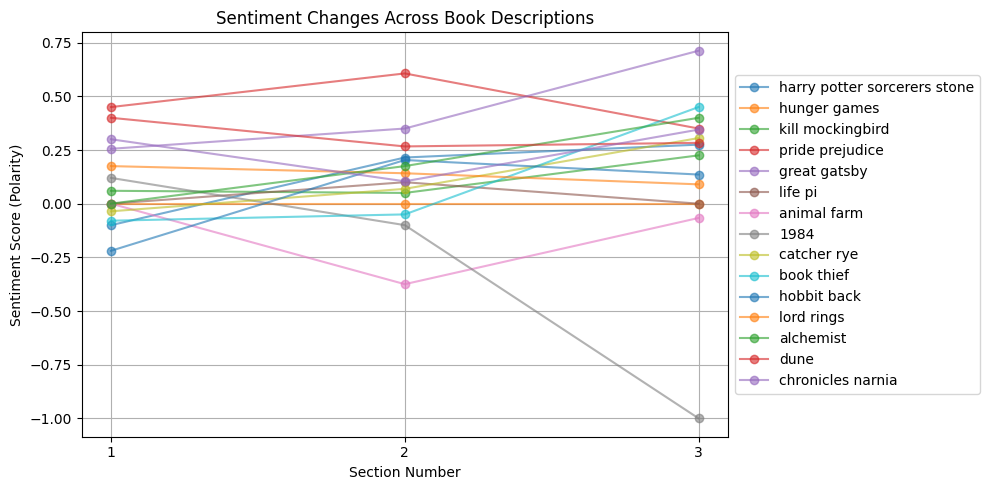

In [67]:
# Function to calculate sentiment score for each section
def analyze_sentiment(text_sections):
    return [TextBlob(section).sentiment.polarity for section in text_sections]

# Extract and analyze sentiment for book descriptions
sentiment_data = []
book_names = []  # <-- Add this to track titles

for book in books:
    if book["Description"] and book["Description"] != "N/A":
        sections = split_text_sections(book["Description"], num_sections=3)  # Split into 3 parts
        sentiment_scores = analyze_sentiment(sections)
        sentiment_data.append(sentiment_scores)
        book_names.append(book["Title"] if "Title" in book else "Unknown")  # <-- Store the book title

# Convert to NumPy array for easy plotting
sentiment_data = np.array(sentiment_data)

# Plot Sentiment Trends
plt.figure(figsize=(10, 5))

for i, scores in enumerate(sentiment_data):
    plt.plot(range(1, 4), scores, marker='o', linestyle='-', alpha=0.6, label=book_names[i])

plt.xlabel("Section Number")
plt.ylabel("Sentiment Score (Polarity)")
plt.title("Sentiment Changes Across Book Descriptions")
plt.xticks([1, 2, 3])
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Place legend outside the plot
plt.tight_layout()
plt.show()


In [68]:
# Save data
with open("book_data.pkl", "wb") as f:
    pickle.dump(books, f)

Ratings Summary:
 count    15.000000
mean      4.195333
std       0.222867
min       3.800000
25%       3.970000
50%       4.280000
75%       4.315000
max       4.540000
Name: Rating, dtype: float64
Unique Ratings:
 [4.47 4.34 4.26 4.29 3.93 3.94 4.   4.2  3.8  4.39 4.54 3.92 4.28]
Updated Ratings Summary:
 count    15.000000
mean      4.195333
std       0.222867
min       3.800000
25%       3.970000
50%       4.280000
75%       4.315000
max       4.540000
Name: Rating, dtype: float64
Unique Ratings After Fix:
 [4.47 4.34 4.26 4.29 3.93 3.94 4.   4.2  3.8  4.39 4.54 3.92 4.28]


<ipython-input-69-c7160ef07858>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Rating"].fillna(df["Rating"].median(), inplace=True)


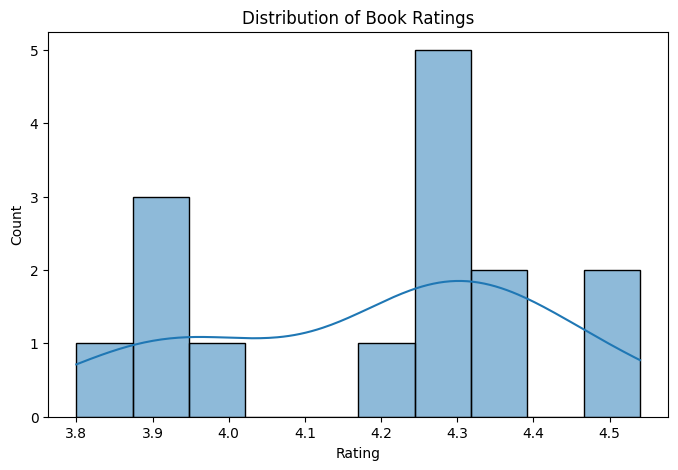

In [69]:
# Step 2: Exploratory Data Analysis (EDA)
df = pd.DataFrame(books)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
# Debug Ratings
print("Ratings Summary:\n", df["Rating"].describe())  # Check min, max, mean, std
print("Unique Ratings:\n", df["Rating"].unique())    # Check if all are same

# Handle missing or invalid ratings
df["Rating"].fillna(df["Rating"].median(), inplace=True)

# Recheck Ratings After Fix
print("Updated Ratings Summary:\n", df["Rating"].describe())
print("Unique Ratings After Fix:\n", df["Rating"].unique())

# Ensure the Rating column has valid numeric values before plotting
if df["Rating"].notna().sum() > 0:
    # Rating Distribution
    plt.figure(figsize=(8,5))
    sns.histplot(df["Rating"].dropna(), bins=10, kde=True)
    plt.title("Distribution of Book Ratings")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()
else:
    print("No valid ratings found. Check if scraping is successful.")

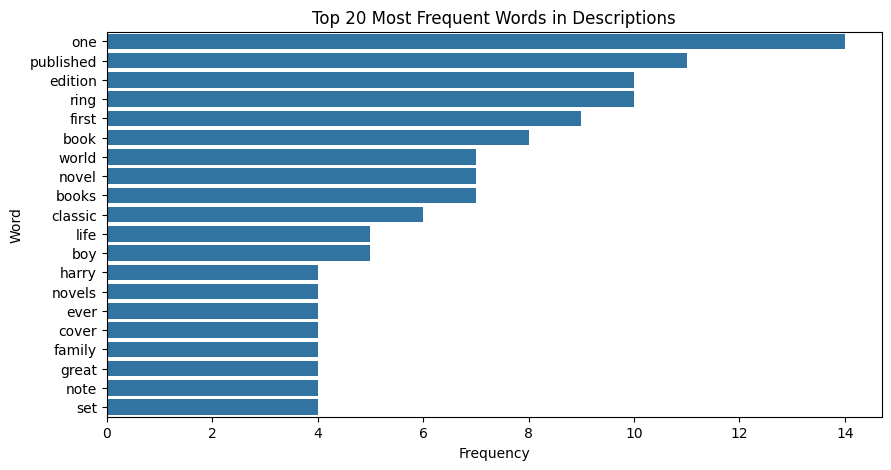

In [70]:
# Word Frequency Analysis
all_text = " ".join(df["Description"].dropna()).lower()
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words).most_common(20)

plt.figure(figsize=(10,5))
sns.barplot(y=[word for word, count in word_counts], x=[count for word, count in word_counts])
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Descriptions")
plt.show()

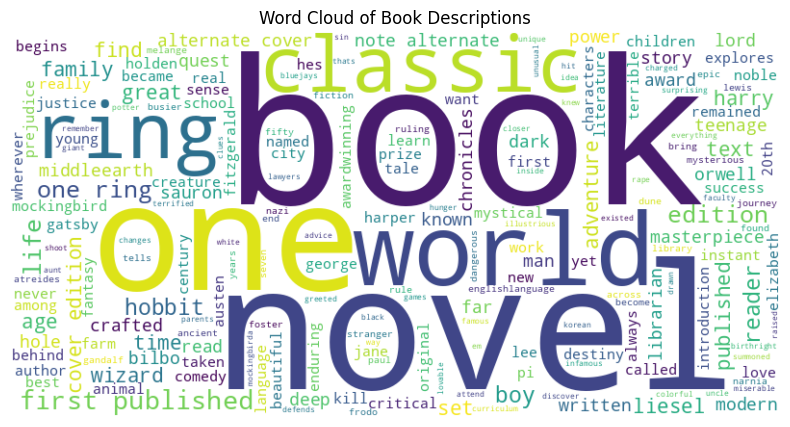

In [71]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Book Descriptions")
plt.show()

In [72]:
# Step 3: Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

df[['Polarity', 'Subjectivity']] = df['Description'].dropna().apply(lambda x: pd.Series(get_sentiment(x)))

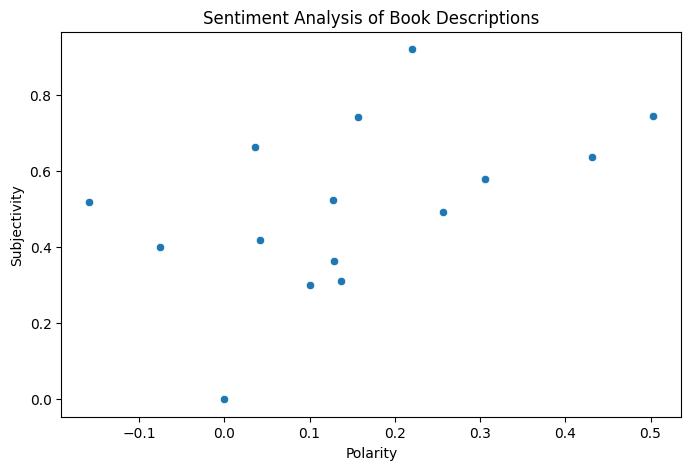

In [73]:
# Sentiment Visualization
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Polarity'], y=df['Subjectivity'])
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.title("Sentiment Analysis of Book Descriptions")
plt.show()

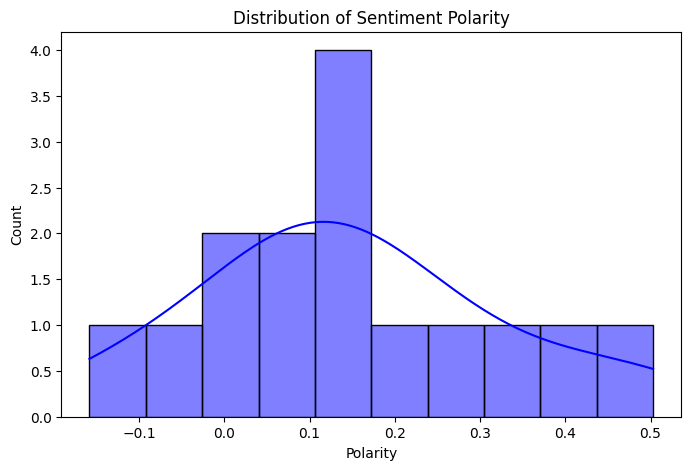

In [74]:
# Sentiment Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Polarity'], bins=10, kde=True, color='blue')
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Polarity")
plt.show()

 Observation:
- Most reviews are **positive**, followed by **neutral**.
- Negative sentiment is relatively low, suggesting general user satisfaction with books.


Observation:
- These books received **consistently high sentiment scores** across reviews.
- They can be considered "safe bets" for recommendation.


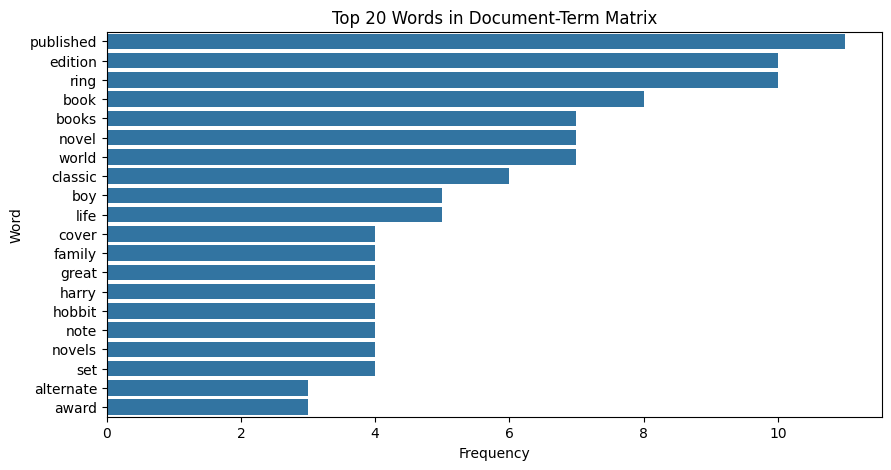

In [75]:
# Step 4: Document-Term Matrix (DTM)
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(df['Description'].dropna())

# Convert to DataFrame
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Top Words in the DTM
word_sums = np.array(dtm_df.sum())
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_sums))
word_freq_sorted = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]

# Plot Top Words from DTM
plt.figure(figsize=(10,5))
sns.barplot(y=[word for word, count in word_freq_sorted], x=[count for word, count in word_freq_sorted])
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Words in Document-Term Matrix")
plt.show()

In [76]:
# Save Cleaned Data
df.to_csv("cleaned_book_data.csv", index=False)
dtm_df.to_csv("document_term_matrix.csv", index=False)

Assignment 5

In [77]:
books = pd.DataFrame(books)

In [78]:
data = pd.read_pickle('book_data.pkl')
data

[{'Title': 'harry potter sorcerers stone',
  'Author': 'N/A',
  'Rating': 4.47,
  'Description': 'harry potter idea famous thats hes raised miserable aunt uncle terrified harry learn hes really wizard parents everything changes harry summoned attend infamous school wizards begins discover clues illustrious birthright surprising way greeted lovable giant unique curriculum colorful faculty unusual school harry finds drawn deep inside mystical world never knew existed closer noble destiny',
  'Genres': ['Fantasy',
   'Fiction',
   'Young Adult',
   'Magic',
   'Childrens',
   'Middle Grade',
   'Audiobook']},
 {'Title': 'hunger games',
  'Author': 'N/A',
  'Rating': 4.34,
  'Description': 'hunger games korean edition',
  'Genres': ['Young Adult',
   'Dystopia',
   'Fiction',
   'Fantasy',
   'Science Fiction',
   'Romance',
   'Adventure']},
 {'Title': 'kill mockingbird',
  'Author': 'N/A',
  'Rating': 4.26,
  'Description': 'shoot bluejays want hit em remember sin kill mockingbirda lawye

In [79]:
from numpy import triu
from scipy.linalg import get_blas_funcs

In [80]:
!pip uninstall scipy -y
!pip install "scipy<1.13"

Found existing installation: scipy 1.12.0
Uninstalling scipy-1.12.0:
  Successfully uninstalled scipy-1.12.0
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)


Topic modeling using Latent Dirichlet Allocation (LDA) on book descriptions

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def basic_clean(text):
    return re.sub(r'[^\w\s]', '', str(text).lower())

books['Clean_Description'] = books['Description'].dropna().apply(basic_clean)

# Create a document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(books['Clean_Description'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out())



Topic #1:
far mystical read story masterpiece tells quest boy edition world

Topic #2:
edition world 2001 begins really noble destiny prejudice success mystical

Topic #3:
novel published boy novels life modern family world classic award

Topic #4:
edition books published book note world cover alternate classic librarians

Topic #5:
ring great hobbit edition book bilbo middleearth wizard text deep


In [82]:
# Get topic distributions per book
topic_assignments = lda.transform(dtm)

# Add main topic to books DataFrame
books['Main_Topic'] = topic_assignments.argmax(axis=1)

# Show examples
print("Sample Topic Assignments:")
print(books[['Title', 'Main_Topic']].head())


Sample Topic Assignments:
                          Title  Main_Topic
0  harry potter sorcerers stone           4
1                  hunger games           3
2              kill mockingbird           3
3               pride prejudice           4
4                  great gatsby           4


In [83]:
# Add to your imports
from nltk import pos_tag

# POS filtering function
def extract_nouns_adjectives(text):
    words = word_tokenize(str(text))
    pos_tags = pos_tag(words)
    return [word for word, pos in pos_tags if pos.startswith('NN') or pos.startswith('JJ')]

# Apply to descriptions
books['POS_Filtered'] = books['Description'].apply(extract_nouns_adjectives)


In [84]:
from sklearn.decomposition import LatentDirichletAllocation

In [85]:
!pip uninstall gensim scipy -y
!pip install "scipy<1.13" "gensim==4.3.2"


Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
Found existing installation: scipy 1.12.0
Uninstalling scipy-1.12.0:
  Successfully uninstalled scipy-1.12.0
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)


In [86]:
!pip show scipy gensim


Name: scipy
Version: 1.12.0
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2024, SciPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions
are met:

1. Redistributions of source code must retain the above copyright
   notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above
   copyright notice, this list of conditions and the following
   disclaimer in the documentation and/or other materials provided
   with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived
   from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRI

In [87]:
!pip install tmtoolkit
!python -m tmtoolkit setup en

error: tmtoolkit is not installed with the dependencies required for text processing; install tmtoolkit with the [recommended] or [textproc] option


In [88]:
# === Coherence Metric Alternative (Scikit-learn Implementation) ===
from sklearn.metrics import pairwise_distances

def calculate_coherence_sklearn(model, vectorizer, texts, top_n=10):
    """Calculate coherence using cosine similarity between top words"""
    topic_words = []
    for topic in model.components_:
        top_features_indices = topic.argsort()[:-top_n-1:-1]
        topic_words.append([vectorizer.get_feature_names_out()[i] for i in top_features_indices])

    coherence_scores = []
    for words in topic_words:
        word_indices = [vectorizer.vocabulary_[word] for word in words if word in vectorizer.vocabulary_]
        if len(word_indices) < 2:
            continue  # Skip topics with insufficient valid words

        # Create vectors using topic component weights
        word_vectors = model.components_[:, word_indices].T

        # Calculate cosine distances (convert to similarities)
        dist_matrix = pairwise_distances(word_vectors, metric='cosine')
        similarities = 1 - dist_matrix

        # Calculate coherence as mean of upper triangle (excluding diagonal)
        upper_triangle = similarities[np.triu_indices(similarities.shape[0], k=1)]
        if len(upper_triangle) > 0:
            coherence_scores.append(np.mean(upper_triangle))

    return np.mean(coherence_scores) if coherence_scores else 0

# Usage after LDA fitting:
coherence_score = calculate_coherence_sklearn(lda, vectorizer, books['Clean_Description'])
print(f"Coherence Score (Cosine Similarity): {coherence_score:.3f}")


Coherence Score (Cosine Similarity): 0.781


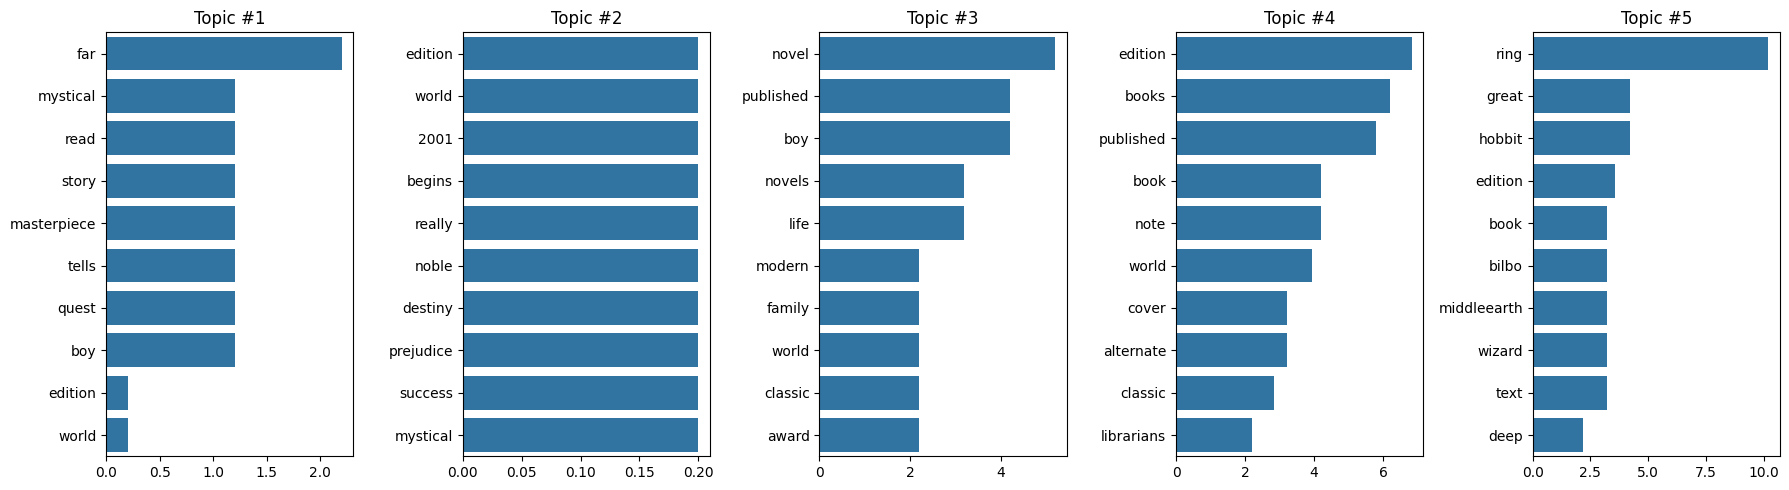

In [89]:
# === 3. Topic Visualization Alternative ===
import matplotlib.pyplot as plt

def visualize_topics(model, feature_names, n_top_words=10):
    """Create manual topic visualization"""
    fig, axes = plt.subplots(nrows=1, ncols=model.n_components, figsize=(18, 5))

    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        sns.barplot(x=np.round(topic[topic.argsort()[:-n_top_words - 1:-1]], 2),
                    y=top_features,
                    ax=axes[idx])
        axes[idx].set_title(f"Topic #{idx+1}")

    plt.tight_layout()
    plt.show()

# Usage:
visualize_topics(lda, vectorizer.get_feature_names_out())


In [90]:
topic_labels = {
    0: "Fantasy Adventure",
    1: "Classic Literature",
    2: "Modern Fiction",
    3: "Book Editions",
    4: "Fantasy Worldbuilding"
}

# Apply labels to the DataFrame
books['Topic_Label'] = books['Main_Topic'].map(topic_labels)

# Show labeled examples
print("Labeled Topics Preview:")
print(books[['Title', 'Topic_Label']].sample(5))


Labeled Topics Preview:
                           Title            Topic_Label
9                     book thief          Book Editions
11                    lord rings  Fantasy Worldbuilding
0   harry potter sorcerers stone  Fantasy Worldbuilding
13                          dune         Modern Fiction
5                        life pi         Modern Fiction


Parameter Tuning Implementation

In [91]:
# === 4. Parameter Tuning Alternative ===
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_components': range(4, 8),
    'learning_decay': [.5, .7, .9]
}

grid_search = GridSearchCV(LatentDirichletAllocation(),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=1,
                           verbose=1)

grid_search.fit(dtm)

print("Best Parameters:", grid_search.best_params_)
print("Best Log-Likelihood:", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'learning_decay': 0.9, 'n_components': 4}
Best Log-Likelihood: -655.3403498395627


Assignment 6

In [92]:
# Combine all book descriptions (or use 'Title' if 'Description' isn't available)
text_corpus = ' '.join(books['Description'].dropna().astype(str).tolist())
print(text_corpus[:500])  # Preview first 500 characters


harry potter idea famous thats hes raised miserable aunt uncle terrified harry learn hes really wizard parents everything changes harry summoned attend infamous school wizards begins discover clues illustrious birthright surprising way greeted lovable giant unique curriculum colorful faculty unusual school harry finds drawn deep inside mystical world never knew existed closer noble destiny hunger games korean edition shoot bluejays want hit em remember sin kill mockingbirda lawyers advice childr


In [93]:
#text cleaning
def basic_clean(text):
    return re.sub(r'[^\w\s]', '', text.lower())

text_corpus = basic_clean(text_corpus)


In [94]:
from collections import defaultdict
import random

def markov_chain(text):
    """Build a Markov chain dictionary from a string of text."""
    words = text.split()
    m_dict = defaultdict(list)
    for current_word, next_word in zip(words[:-1], words[1:]):
        m_dict[current_word].append(next_word)
    return dict(m_dict)

def generate_sentence(chain, count=15):
    """Generate a sentence of 'count' words from a Markov chain."""
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()
    for _ in range(count - 1):
        next_words = chain.get(word1)
        if not next_words:
            word1 = random.choice(list(chain.keys()))
            next_words = chain[word1]
        word2 = random.choice(next_words)
        sentence += ' ' + word2
        word1 = word2
    sentence += '.'
    return sentence

# Example usage with your book descriptions:
all_descriptions = ' '.join(books['Description'].dropna())
chain = markov_chain(all_descriptions)
print(generate_sentence(chain, count=20))


Dwarf legolas elf boromir gondor tall mysterious stranger called strider paulo coelhos masterpiece meaning message still ferociously fresh among terrifying.


In [95]:
for _ in range(5):
    print(generate_sentence(chain, count=20))


Forged one book superb comedy george orwells prescience modern life—the ubiquity television distortion language—and ability construct thorough version hell required.
Dry bare sandy hole nothing sit eat hobbithole means comfortwritten jrr tolkien ’ revisions foreword granddaughter new york city seeking.
Schoolfleeing crooks pencey prep pinballs around new introduction hobbit bilbo bagginsfrom saurons fastness dark lord forged one ring filling power.
1925 quintessential novel included times liesels world middleearth recounts adventures reluctant hero powerful dangerous ring taken overworked mistreated animals flaming.
Drawing reader ask one ring find one ring gandalf gollum spectacular world thing value spice melange drug capable extending life.


In [96]:
#generate new text
import random

def generate_text(chain, length=50, seed_word=None):
    """Generates text using a Markov chain."""
    if not seed_word:
        seed_word = random.choice(list(chain.keys()))

    words = [seed_word]
    for _ in range(length - 1):
        next_words = chain.get(words[-1], None)
        if not next_words:
            break
        words.append(random.choice(next_words))

    return ' '.join(words)

# Example: generate a fake "book blurb"
generated_blurb = generate_text(chain, length=60)
print(generated_blurb)


terrible neon loneliness seedy glamour mingled sense possibility emptiness holden caulfield expelled yet another schoolfleeing crooks pencey prep pinballs around new introduction national book award formed basis undoubtedly grandest epic battles good evil—what could rule one ring filling power spread far different far wide sauron dark lord destroy ring gandalf gollum spectacular world never knew existed closer noble family lifelong
